In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34806")
client

<Client: 'tcp://127.0.0.1:34806' processes=6 threads=6, memory=48.00 GiB>

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import os
import pickle

import SAM
import cluster_utils as flt

from sklearn.decomposition import PCA

#import importlib
#importlib.reload(SAM)
#importlib.reload(flt)

from dask import delayed

In [4]:
# Number of classes 
n_classes = 7
model_folder = 'model'
data_folder = 'data'

ids = ['r1i1p1f2', 'r3i1p1f2', 'r2i1p1f2', 'r8i1p1f2', 'r4i1p1f2', 'r5i1p1f3', 'r7i1p1f3', 'r9i1p1f2', 'r6i1p1f3', 'r10i1p1f2']
#ids = ['r6i1p1f3', 'r10i1p1f2']
mask = np.load('data/mask.npy', allow_pickle=True)
areas = {}
mean_lats={}
avg_profiles={}

In [6]:
for m_id in ids:
    
    print('Starting {}'.format(m_id))
    path_id = '{}/{}'.format(model_folder, m_id)
    path_n = '{}/{}/{}'.format(model_folder, m_id, n_classes)
    path_n_data = '{}/{}/{}'.format(data_folder, m_id, n_classes)
    
    with open('{}/pca.obj'.format(path_id), 'rb') as file:
        pca = pickle.load(file)
        file.close()
        
    with open('{}/gmm.obj'.format(path_n), 'rb') as file:
        gmm = pickle.load(file)
        file.close()
    
    options = {'memberId' : m_id}
    data = flt.retrieve_profiles(timeRange = slice('1965-01', '1994-12'), mask=mask, options=options)
    data_sampled = flt.normalise_data(data, ('n', 'time'))
    data_trans = flt.pca_transform(data_sampled, pca)
   # data_classes = SAM.BW_filter(flt.gmm_prob(data_trans, gmm), 4, 1/1.5, 'time', btype='high').argmax('k')
    data_classes = flt.gmm_classify(data_trans, gmm)
    print('Finished setup for {}'.format(m_id))
    modal_classes=flt.modal_classes(data_classes)
    modal_classes.reset_index('n').to_netcdf('{}/modal_classes.nc'.format(path_n))
    
    areas[m_id] = flt.count_area(data_classes.chunk(dict(n=-1)), n_classes).compute()
    mean_lats[m_id] = flt.mean_lat(data_classes.chunk(dict(n=-1)), n_classes).compute()
    avg_profiles[m_id] = flt.avg_profiles(data, data_classes, n_classes)
    
    if not os.path.isdir(path_n_data):
        os.makedirs(path_n_data)
    with open('{}/areas.obj'.format(path_n_data), 'wb') as file:
        pickle.dump(areas[m_id], file)
        file.close()
    with open('{}/mean_lats.obj'.format(path_n_data), 'wb') as file:
        pickle.dump(mean_lats[m_id], file)
        file.close()
    with open('{}/avg.obj'.format(path_n_data), 'wb') as file:
            pickle.dump(avg_profiles[m_id], file)
            file.close()
    
print('Done!')

Starting r1i1p1f2
Finished setup for r1i1p1f2
Starting r3i1p1f2
Finished setup for r3i1p1f2
Starting r2i1p1f2
Finished setup for r2i1p1f2
Starting r8i1p1f2
Finished setup for r8i1p1f2
Starting r4i1p1f2
Finished setup for r4i1p1f2
Starting r5i1p1f3
Finished setup for r5i1p1f3
Starting r7i1p1f3
Finished setup for r7i1p1f3
Starting r9i1p1f2
Finished setup for r9i1p1f2
Starting r6i1p1f3
Finished setup for r6i1p1f3
Starting r10i1p1f2
Finished setup for r10i1p1f2
Done!


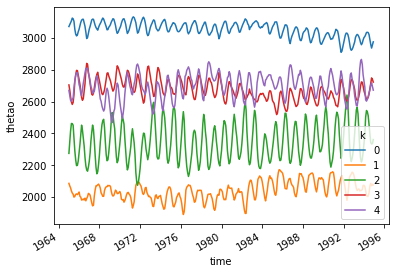

In [9]:
areas['r1i1p1f2'].plot(x='time',hue='k')

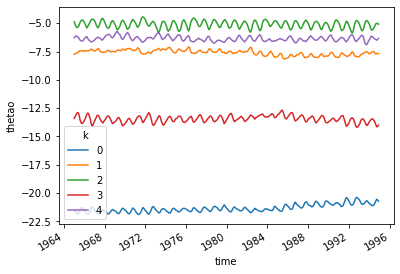

In [10]:
mean_lats['r1i1p1f2'].plot(x='time',hue='k')

In [11]:
ts=['1965-01', '1994-12']
SAM_data = []
for i in ids:
    options = {'memberId' : i}
    SAM_data.append(SAM.retrieve_SAM(timeRange=slice(ts[0], ts[-1]), options=options))

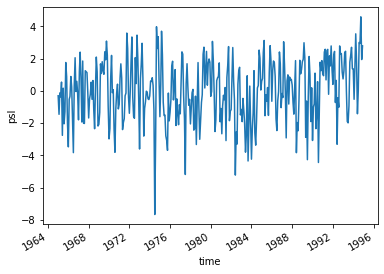

In [13]:
SAM_data[0].plot(x='time')

In [14]:
area_anom=SAM.monthly_mean(areas['r1i1p1f2'])
lat_anom=SAM.monthly_mean(mean_lats['r1i1p1f2'])

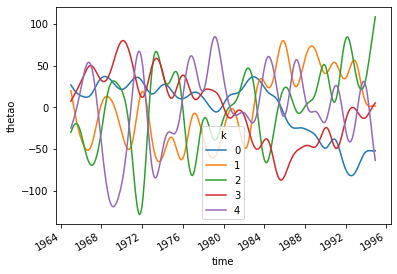

In [30]:
SAM.BW_filter(area_anom,4,1/12,'time').plot(hue='k')

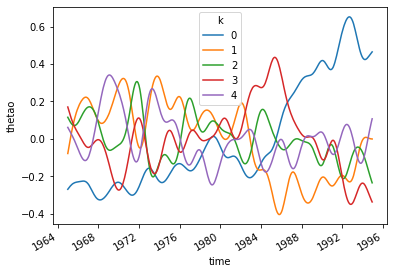

In [29]:
SAM.BW_filter(lat_anom,4,1/12,'time').plot(hue='k')

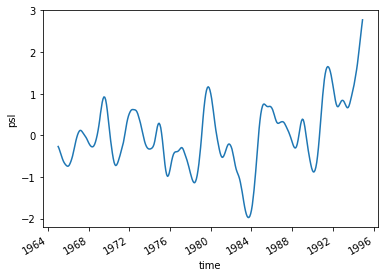

In [22]:
SAM.BW_filter(SAM_data[0],2,1/12,'time').plot()

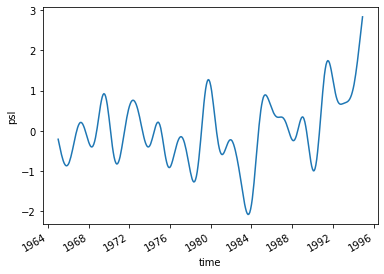

In [28]:
SAM.BW_filter(SAM_data[0],4,1/12,'time').plot()

In [32]:
import scipy.stats as stats
def new_linregress(x,y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return np.array([slope, intercept, r_value, p_value, std_err])
def lin_regress(X,Y,indims,dtype='float64'):    
    stats = xr.apply_ufunc(
    new_linregress,  # first the function
    X,  # now arguments in the order expected by func
    Y,  # as above
    input_core_dims=indims,  # list with one entry per arg
    output_core_dims=[['parameter']],  # returned data has one dimension
    vectorize=True,  # loop over non-core dims
    dask='parallelized',
    output_dtypes=[dtype],  # one per output
    dask_gufunc_kwargs={'output_sizes':{"parameter": 5}},
#    output_sizes={"parameter": 5},
    )
    stats['parameter']=('parameter',["slope","intercept","r_value","p_value","std_err"])
    return stats

In [42]:
XX=SAM.BW_filter(SAM_data[0],4,1/12,'time')
YY=SAM.BW_filter(area_anom,4,1/12,'time')
stats_SAM_area=lin_regress(XX,YY,[['time'],['time']])
YY=SAM.BW_filter(lat_anom,4,1/12,'time')
stats_SAM_lat=lin_regress(XX,YY,[['time'],['time']])

In [41]:
(stats_SAM_area.sel(parameter='r_value')**2).load()

<xarray.DataArray (k: 5)>
array([0.26053836, 0.07182561, 0.10778489, 0.00893049, 0.0136773 ])
Coordinates:
    parameter  <U9 'r_value'
Dimensions without coordinates: k

In [40]:
stats_SAM_area.sel(parameter='p_value').load()

<xarray.DataArray (k: 5)>
array([2.81385507e-25, 2.44261171e-07, 1.71001115e-10, 7.33239525e-02,
       2.64954194e-02])
Coordinates:
    parameter  <U9 'p_value'
Dimensions without coordinates: k

In [43]:
(stats_SAM_lat.sel(parameter='r_value')**2).load()

<xarray.DataArray (k: 5)>
array([0.22343335, 0.05730944, 0.08628458, 0.10637257, 0.00073016])
Coordinates:
    parameter  <U9 'r_value'
Dimensions without coordinates: k

In [44]:
stats_SAM_lat.sel(parameter='p_value').load()

<xarray.DataArray (k: 5)>
array([1.94096833e-21, 4.36198322e-06, 1.34876546e-08, 2.28395396e-10,
       6.09346201e-01])
Coordinates:
    parameter  <U9 'p_value'
Dimensions without coordinates: k